# Calibration Of Real Data

This notebook demonstrates how we can calibrate the network of sensors using the colocation events.

In [4]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
import gpflow
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import download_airnow_web
import pyproj
%matplotlib inline
import numpy as np
import pandas as pd
from glob import glob

### Methods

Helper methods for accessing and processing data

In [5]:
def processBAMdata(pathtofolders,channelids):
    """
    Process the downloaded data from google drive containing BAM data.
    The BAM data is organised into folders, such as:
        rootfolder/Y24516 Makerere BAM/20200730/DT091755.CSV
    the root folder also contains a metadata file that stores the
    latitude, longitude and time of the sensors.
    pathtofolders = the path to the root folder
    channelids = dictionary of what numeric id to give each sensor, for example:
        {'Y24517':-24517,'Y24516':-24516}
    Returns a dataframe of BAM data, with only status=0 rows.
    """
    metadf = pd.read_excel(pathtofolders+'/BAM Metadata.xlsx')
    print("Device Ids: ")
    print(metadf['Id'].unique())
    allbamdf = []
    for fn in glob(pathtofolders+'/*/*/*.CSV'):
        bamdf = pd.read_csv(fn,skiprows=5)
        ch_id = fn[len(pathtofolders)+1:].split('/')[0].split(' ')[0]
        thismetadf = metadf[metadf['Id']==ch_id]
        bamdf = bamdf[bamdf['Status']==0]
        bamdf['latitude']=thismetadf['Latitude'].iloc[0]
        bamdf['longitude']=thismetadf['Longitude'].iloc[0]
        bamdf['pm2_5'] = bamdf['ConcHR(ug/m3)']
        bamdf['created_at'] = bamdf['Time']
        bamdf['channel_id'] = channelids[ch_id]
        allbamdf.append(bamdf)
    return pd.concat(allbamdf)
    
def loaddata(bigquery_account_json,nextdays=5):
    """
    Load data from main GCP database.
    Pass it the path to your CGP key.
    Returns a dataframe of all the sensor data.
    
    Currently this version just downloads the next five days of data from the oldest data in the cache.
    If you want to download more, change 'nextdays' parameter to a larger number. If you set it to, for
    example 30000 it will download all the data.
    """
    client = bigquery.Client.from_service_account_json(bigquery_account_json)
    try:
        df = pickle.load(open('alldata.p','rb'))
        mostrecent = df['created_at'].max()
        nexttimestep = mostrecent + pd.Timedelta(nextdays,'day')
        mostrecent = mostrecent.strftime('%Y-%m-%d')
        
        
        nexttimestep = nexttimestep.strftime('%Y-%m-%d')
        print("Found cache file containing data up to %s" % mostrecent)
        print("Downloading more data to date %s" % nexttimestep)
        sql = """SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms` WHERE (created_at >= DATETIME('%s')) AND (created_at < DATETIME('%s'))""" % (mostrecent,nexttimestep)
        print("SQL query:")
        print(sql)
        d = client.query(sql)
        print("Query complete, converting to dataframe...")
        d = d.to_dataframe()     
        print("done")
        print(d)
        print("Concatenating with cached data...")
        df = pd.concat([df,d]) #ugh, memory issues: https://www.confessionsofadataguy.com/solving-the-memory-hungry-pandas-concat-problem/
        print("Dropping duplicates...")
        df = df.drop_duplicates() #we are likely to have duplicates as the create_at threshold is a bit vague
    except FileNotFoundError:
        print("cache file ('alldata.p') not found. Downloading entire dataset, this may take some time.")
        sql = """SELECT * FROM `airqo-250220.thingspeak.clean_feeds_pms`"""
        df = client.query(sql).to_dataframe()
    print("Saving new cache")
    pickle.dump(df,open('alldata.p','wb'))
    return df

def combinedatasets(df,otherdf, distfromboxcentre = 40e3, boxlat=0.313611, boxlong=32.581111):
    """
    Merge 'otherdf' into 'df'.
    Only include data from either that is within distfromboxcentre (in metres) from boxlat and boxlong.
    Adds x and y columns for Northings and Eastings.
    """

    df = pd.concat([df, otherdf[['created_at','channel_id','pm2_5','latitude','longitude']]])
    #Convert to northings and eastings
    epsg3857 = pyproj.Proj(init='epsg:3857') #EPSG:3857 -- WGS84 Web Mercator [used by websites]
    wgs84 = pyproj.Proj(init='EPSG:4326') #WGS 84 [used by GPS satellite system]
    boxcentre = pyproj.transform(wgs84,epsg3857,boxlong,boxlat)
    longs = df['longitude'].tolist()
    lats = df['latitude'].tolist()

    df['x'],df['y'] = pyproj.transform(wgs84,epsg3857,longs,lats)

    #Only keep items that are in a box around Kampala
    df = df[(df['x']>boxcentre[0]-distfromboxcentre)]
    df = df[(df['x']<boxcentre[0]+distfromboxcentre)]
    df = df[(df['y']>boxcentre[1]-distfromboxcentre)]
    df = df[(df['y']<boxcentre[1]+distfromboxcentre)]
    return df

def build_encounters(df,prox = 20,timeprox = 30):
    """
    Build a new dataframe containing the pairs of measurements that happen near each other.
    
    Input dataframe needs these columns:
        channel_id
        created_at
        latitude (lat/long only included to check they are 'sensible' and not NAN)
        longitude
        pm2_5
        x (Easting and Northing in m)
        y        
    prox = proximity in metres
    timeprox = proximity in minutes
    
    Returns a dataframe containing two copies of all the columns of the original (one for each sensor)
    with additionally a column for timedelta and dist (in m) between the two observations.
    """
    dfs = []
    encounters = None
    for cid in df['channel_id'].unique():
        df['created_at_2']=df['created_at']
        dfs.append(df[df['channel_id']==cid])
    for i,d1 in enumerate(dfs):
        #for d2 in dfs[i+1:]:
        for j,d2 in enumerate(dfs):
            if i==j:continue
            newdf = pd.merge_asof(d1.sort_values("created_at"),d2.sort_values("created_at"),on='created_at',tolerance=pd.Timedelta(timeprox,'minutes'),direction='nearest',suffixes=('_sensorA', '_sensorB')). \
                dropna(subset=["created_at","created_at_2_sensorA",'latitude_sensorA','longitude_sensorA', 'latitude_sensorB', 'longitude_sensorB','pm2_5_sensorA','pm2_5_sensorB'])
            #leaving this line in might make it quicker, as I compute a sqrt (somewhat unnecessarily for a lot of data)
            #newdf = newdf[(np.abs(newdf['x_sensorA']-newdf['x_sensorB'])<prox) & (np.abs(newdf['y_sensorA']-newdf['y_sensorB'])<prox)]
            newdf['dist'] = np.sqrt((newdf['x_sensorA']-newdf['x_sensorB'])**2 + (newdf['y_sensorA']-newdf['y_sensorB'])**2)
            newdf = newdf[newdf['dist']<prox]
            newdf['timedelta'] = np.abs(newdf['created_at_2_sensorA']-newdf['created_at_2_sensorB'])
            encounters = pd.concat([encounters,newdf])
        print("%d of %d (%d encounters recorded)" % (i+1,len(dfs),len(encounters)))
    return encounters

def plotsensorencounters(df,box=100):
    """
    For each sensor find its median location and plot all the sensors around it over all time.
    This just was useful to confirm that sensor visits were as intended.
    """
    i=0
    unq = df['channel_id'].unique()
    len(unq)
    plt.figure(figsize=[8*4,8*4])
    for cid in unq:
        i+=1
        boxc=[0,0]
        boxc[0] = np.median(df[df['channel_id']==cid]['x'])
        boxc[1] = np.median(df[df['channel_id']==cid]['y'])
        plt.subplot(8,8,i)
        if cid in [930428,930430]: continue

        for channel_id in unq:
            #print(channel_id)
            chandf = df[df['channel_id']==channel_id]
            chandf = chandf[(chandf['x']>boxc[0]-box) & (chandf['x']<boxc[0]+box) & (chandf['y']>boxc[1]-box) & (chandf['y']<boxc[1]+box)]
            if channel_id in [-1,930428,930430]:
                dotsize = 3
            else:
                dotsize = 3
            if len(chandf)>0:
                plt.scatter(chandf['x'],chandf['y'],dotsize,label="%d (%d)" % (channel_id,len(chandf)))
        plt.legend()
        plt.xlim([boxc[0]-box,boxc[0]+box])
        plt.ylim([boxc[1]-box,boxc[1]+box])
        plt.title(cid)
        #plt.plot(embassyxy['x'],embassyxy['y'],'x',markersize=20)
        plt.grid()

# Download and organise data

The following code can take a while as it downloads data from servers and merges big dataframes. If you want to analyse the data and have already downloaded it - you might be best skipping straight to the analysis step below.

This method takes a long time as it downloads data from GCP.
Typically I comment it out and just use the local copy.

In [16]:
import pickle
#airqodf = loaddata("/home/mike/.gcp_keys/airqo-250220-e1dc140554a6.json")
#pickle.dump(airqodf,open('airqodf.p','wb'))
airqodf = pickle.load(open('airqodf.p','rb'))

Download latest embassy data, add its latitude, longitude, channel_id (-1) and add new columns renaming them to our conventions.

In [17]:
embassydf = download_airnow_web.download('Kampala')
embassydf['pm2_5'] = embassydf['Raw Conc.']
embassydf['created_at'] = embassydf['Date (LT)']
embassydf['channel_id']=-1
embassydf['latitude'] = 0.299333
embassydf['longitude'] = 32.592539

The BAM data has been copied from the google folder Joel set up. This method parses that data and converts to a dataframe.

In [18]:
bamdf = processBAMdata('/home/mike/Documents/Research/air/BAM Data',{'Y24517':-24517,'Y24516':-24516})

Device Ids: 
['Y24517' 'Y24516']


In [143]:
bamdf

,Time,ConcRT(ug/m3),ConcHR(ug/m3),ConcS(ug/m3),Flow(lpm),WS(m/s),WD(Deg),AT(C),RH(%),BP(mmHg),FT(C),FRH(%),Status,latitude,longitude,pm2_5,created_at,channel_id
2,2020-09-19 17:00:00,50.0,61.3,71.3,16.59,0.3,151,27.6,58,660.3,30.9,38,0,0.331705,32.609860,61.3,2020-09-19 14:00:00+00:00,-24517
3,2020-09-19 18:00:00,79.5,90.1,103.9,16.59,0.3,165,25.7,65,660.7,30.1,41,0,0.331705,32.609860,90.1,2020-09-19 15:00:00+00:00,-24517
4,2020-09-19 19:00:00,65.1,66.9,76.6,16.59,0.3,120,23.6,75,661.2,27.7,49,0,0.331705,32.609860,66.9,2020-09-19 16:00:00+00:00,-24517
7,2020-09-19 22:00:00,27.1,26.8,30.3,16.58,0.6,314,21.1,76,662.9,25.5,50,0,0.331705,32.609860,26.8,2020-09-19 19:00:00+00:00,-24517
8,2020-09-19 23:00:00,16.1,12.8,14.5,16.59,0.6,310,20.2,77,662.8,25.6,46,0,0.331705,32.609860,12.8,2020-09-19 20:00:00+00:00,-24517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,2020-07-30 05:00:00,21.8,19.8,22.5,16.59,0.0,0,19.7,92,658.2,27.6,47,0,0.333505,32.568577,19.8,2020-07-30 02:00:00+00:00,-24516
611,2020-07-30 06:00:00,14.4,19.4,22.0,16.59,0.0,0,19.4,94,658.6,27.9,46,0,0.333505,32.568577,19.4,2020-07-30 03:00:00+00:00,-24516
612,2020-07-30 07:00:00,37.2,40.9,46.3,16.59,0.0,0,19.6,93,658.9,28.5,45,0,0.333505,32.568577,40.9,2020-07-30 04:00:00+00:00,-24516
613,2020-07-30 08:00:00,45.0,54.3,61.5,16.59,0.0,0,20.0,92,659.4,28.9,44,0,0.333505,32.568577,54.3,2020-07-30 05:00:00+00:00,-24516


In [141]:
ls "/home/mike/Documents/Research/air/BAM Data"

'BAM Metadata.xlsx'  'Y24516 Makerere BAM'/  'Y24517 Nakawa BAM'/


I found that I ran out of memory doing some of this, so I drop many of the columns from the GCP airqo database.

In [19]:
airqodf = airqodf.drop(['entry_id','pm10','voltage','s2_pm10','altitude','wind','no_sats','hdope'],axis=1)

Here we move everything to UTC:
- the AirQo data is already in UTC
- the BAM and Embassy data are in local time, so they get converted.

We then call our 'combinedatasets' method to merge the three sets together, and save them.

In [ ]:
airqodf['created_at'] = airqodf['created_at'].dt.tz_localize('UTC')
bamdf['created_at'] = pd.to_datetime(bamdf['Time'],format="%Y-%m-%d %H:%M:%S").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')
embassydf['created_at'] = pd.to_datetime(embassydf['created_at'],format="%Y-%m-%d %I:%M %p").dt.tz_localize('Africa/Kampala').dt.tz_convert('UTC')

df = combinedatasets(airqodf,bamdf)
df = combinedatasets(df,embassydf)
pickle.dump(df,open('alldataprocessed.p','wb'))

# Analysis

The above processing and collecting of the data is quite time consuming, so to use a saved version we just can start here.

In [22]:
df = pickle.load(open('alldataprocessed.p','rb'))

/home/mike/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


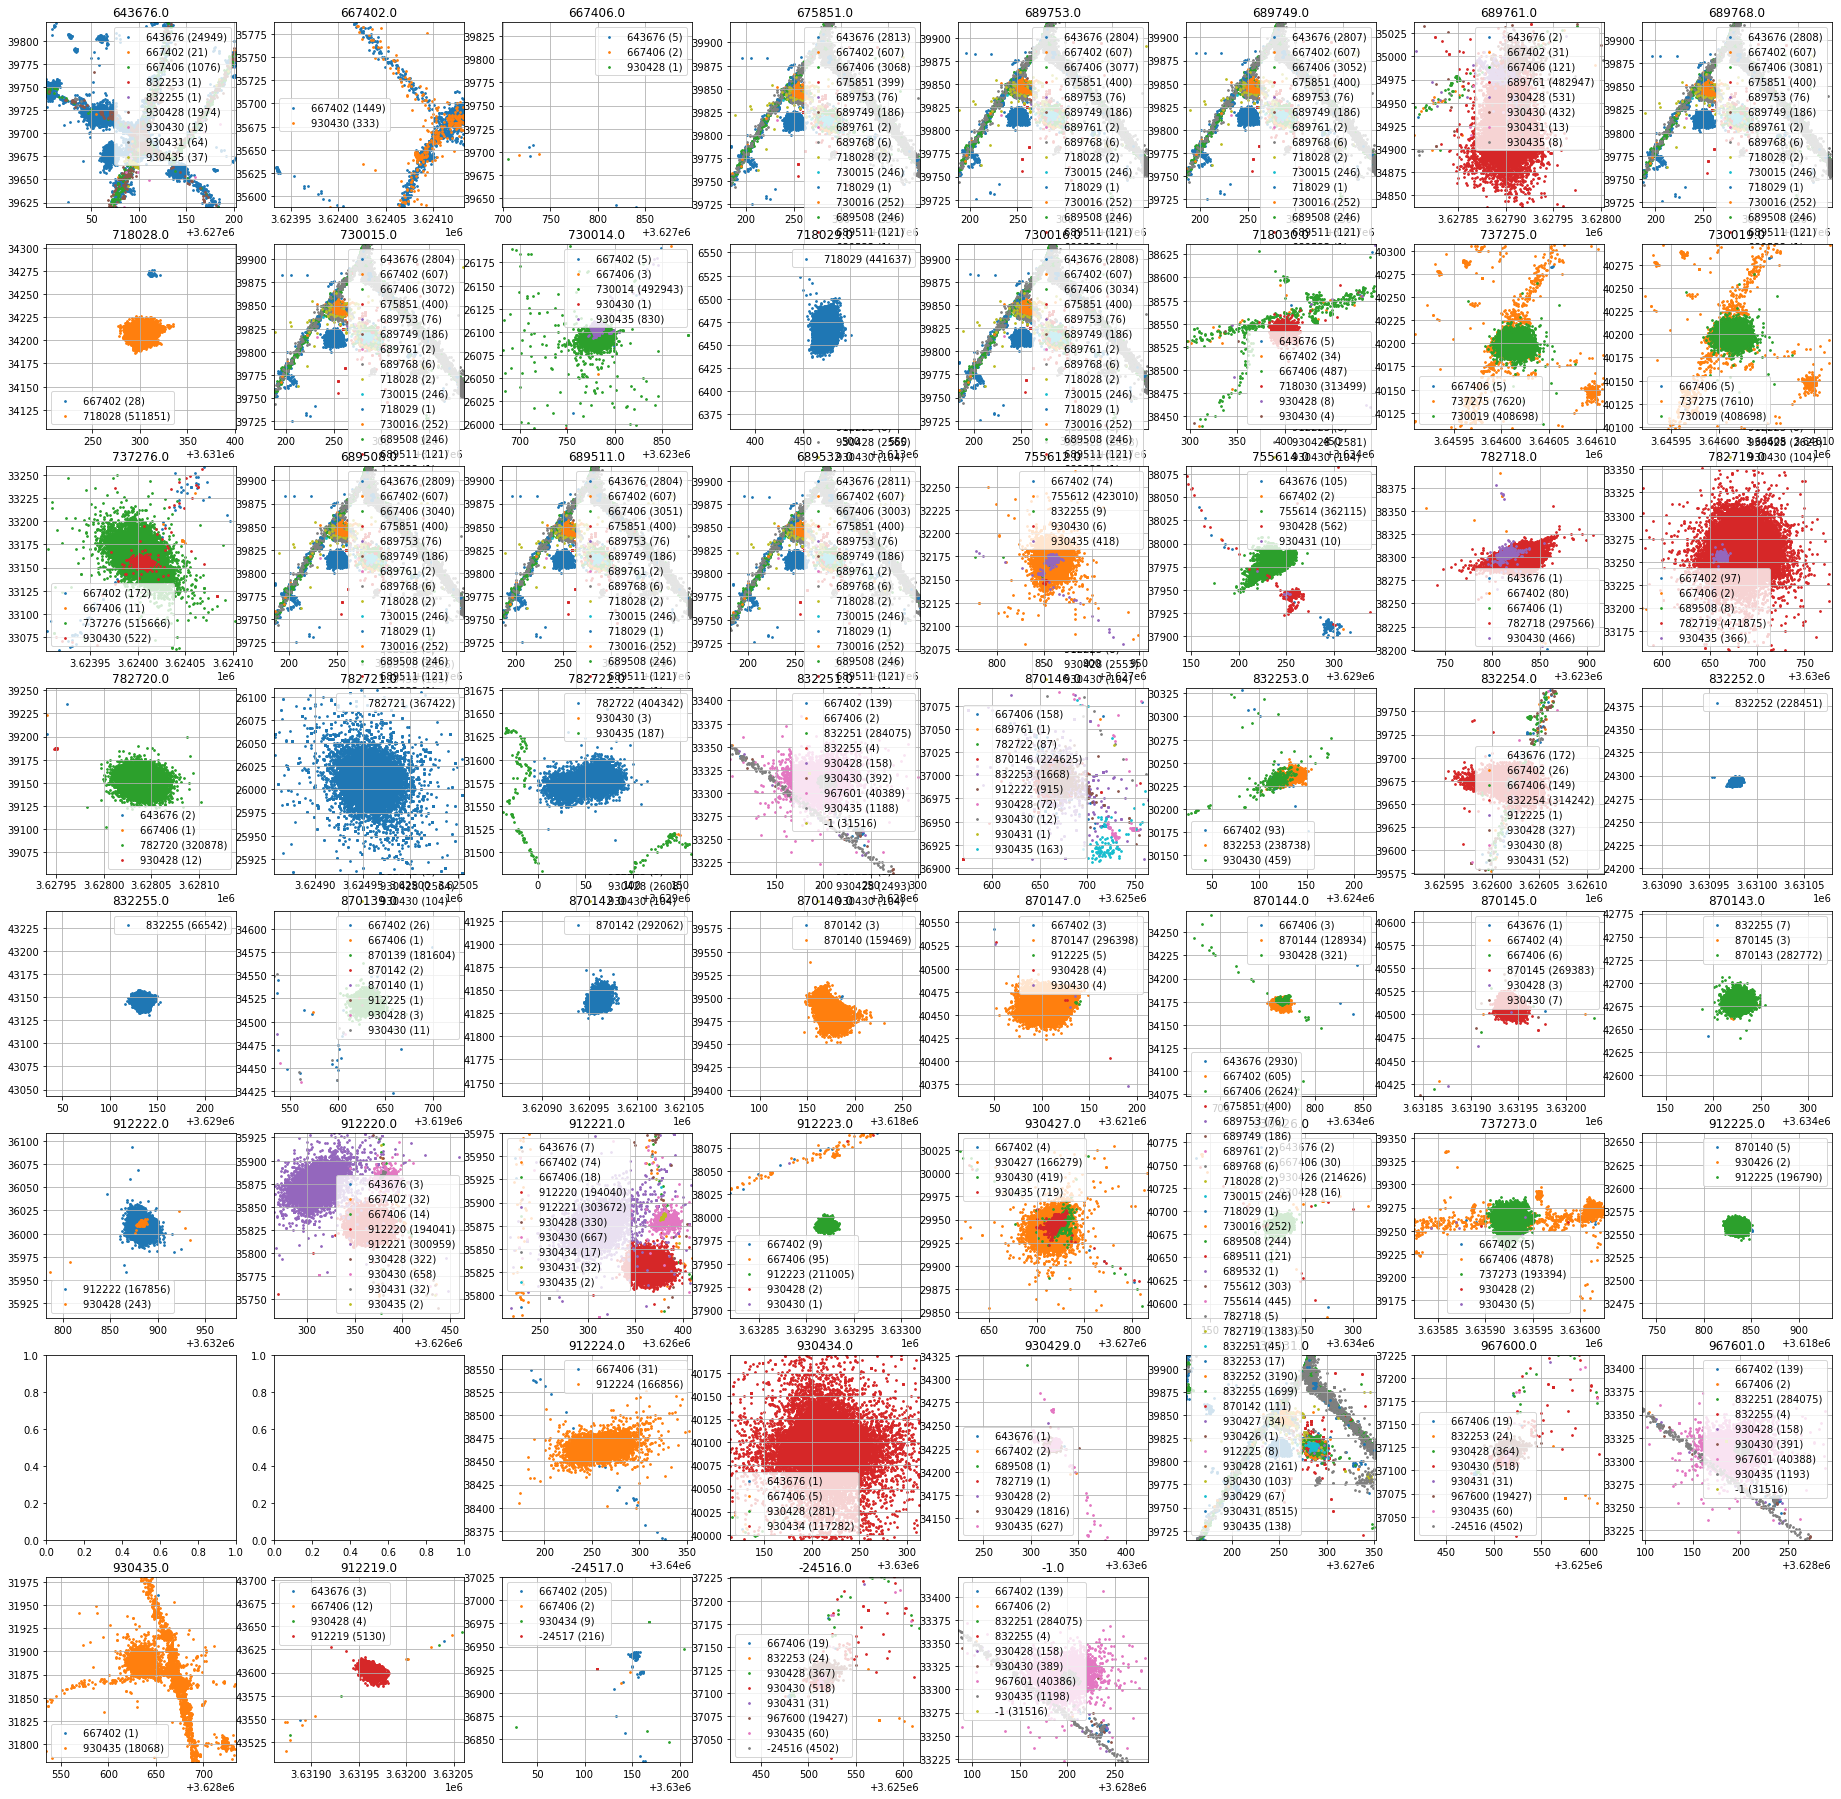

In [130]:
plotsensorencounters(df)

In [23]:
#just use recent data
df = df[df['created_at']>pd.Timestamp('2020-07-15',tz='UTC')]

In [24]:
df

,created_at,channel_id,pm2_5,s2_pm2_5,latitude,longitude,temperature,humidity,x,y
3,2020-07-25 16:15:29+00:00,782718.0,73.88,72.17,0.344043,32.553215,NaN,NaN,3.623807e+06,38298.921724
39,2020-07-25 16:24:03+00:00,782718.0,66.62,64.18,0.344042,32.553261,NaN,NaN,3.623812e+06,38298.810403
77,2020-07-25 17:06:54+00:00,718029.0,80.10,62.77,0.057972,32.460377,NaN,NaN,3.613473e+06,6453.414621
80,2020-07-26 05:09:32+00:00,718029.0,43.32,37.13,0.057973,32.460392,NaN,NaN,3.613474e+06,6453.525941
81,2020-07-25 11:49:09+00:00,870142.0,53.27,51.27,0.375821,32.527580,NaN,NaN,3.620954e+06,41836.502350
...,...,...,...,...,...,...,...,...,...,...
89,2020-10-04 17:00:00+00:00,-1.0,59.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
90,2020-10-04 18:00:00+00:00,-1.0,58.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
91,2020-10-04 19:00:00+00:00,-1.0,48.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717
92,2020-10-04 20:00:00+00:00,-1.0,56.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717


Here we build the encounters dataframe, this records all the times two sensors are near each other.
It can take a few minutes, so if you've already run it - skip to loading it on the next line.

In [25]:
encounters = build_encounters(df)
pickle.dump(encounters,open('encounters.p','wb'))

1 of 47 (139 encounters recorded)
2 of 47 (139 encounters recorded)
3 of 47 (139 encounters recorded)
4 of 47 (141 encounters recorded)
5 of 47 (142 encounters recorded)
6 of 47 (146 encounters recorded)
7 of 47 (146 encounters recorded)
8 of 47 (146 encounters recorded)
9 of 47 (146 encounters recorded)
10 of 47 (498 encounters recorded)
11 of 47 (498 encounters recorded)
12 of 47 (498 encounters recorded)
13 of 47 (498 encounters recorded)
14 of 47 (498 encounters recorded)
15 of 47 (498 encounters recorded)
16 of 47 (621 encounters recorded)
17 of 47 (621 encounters recorded)
18 of 47 (761 encounters recorded)
19 of 47 (761 encounters recorded)
20 of 47 (761 encounters recorded)
21 of 47 (922 encounters recorded)
22 of 47 (922 encounters recorded)
23 of 47 (1193 encounters recorded)
24 of 47 (1193 encounters recorded)
25 of 47 (1193 encounters recorded)
26 of 47 (1193 encounters recorded)
27 of 47 (1337 encounters recorded)
28 of 47 (1362 encounters recorded)
29 of 47 (1362 encounte

In [26]:
encounters = pickle.load(open('encounters.p','rb'))

Just makes a list of unique channel ids.

In [34]:
#all channels...
#unq = df['channel_id'].unique()

#just those with encounters...
unq = np.unique(np.r_[encounters['channel_id_sensorA'].unique(),encounters['channel_id_sensorB'].unique()])

Plots all the channel pairs, to let us see where our encounter data lies, and how it looks

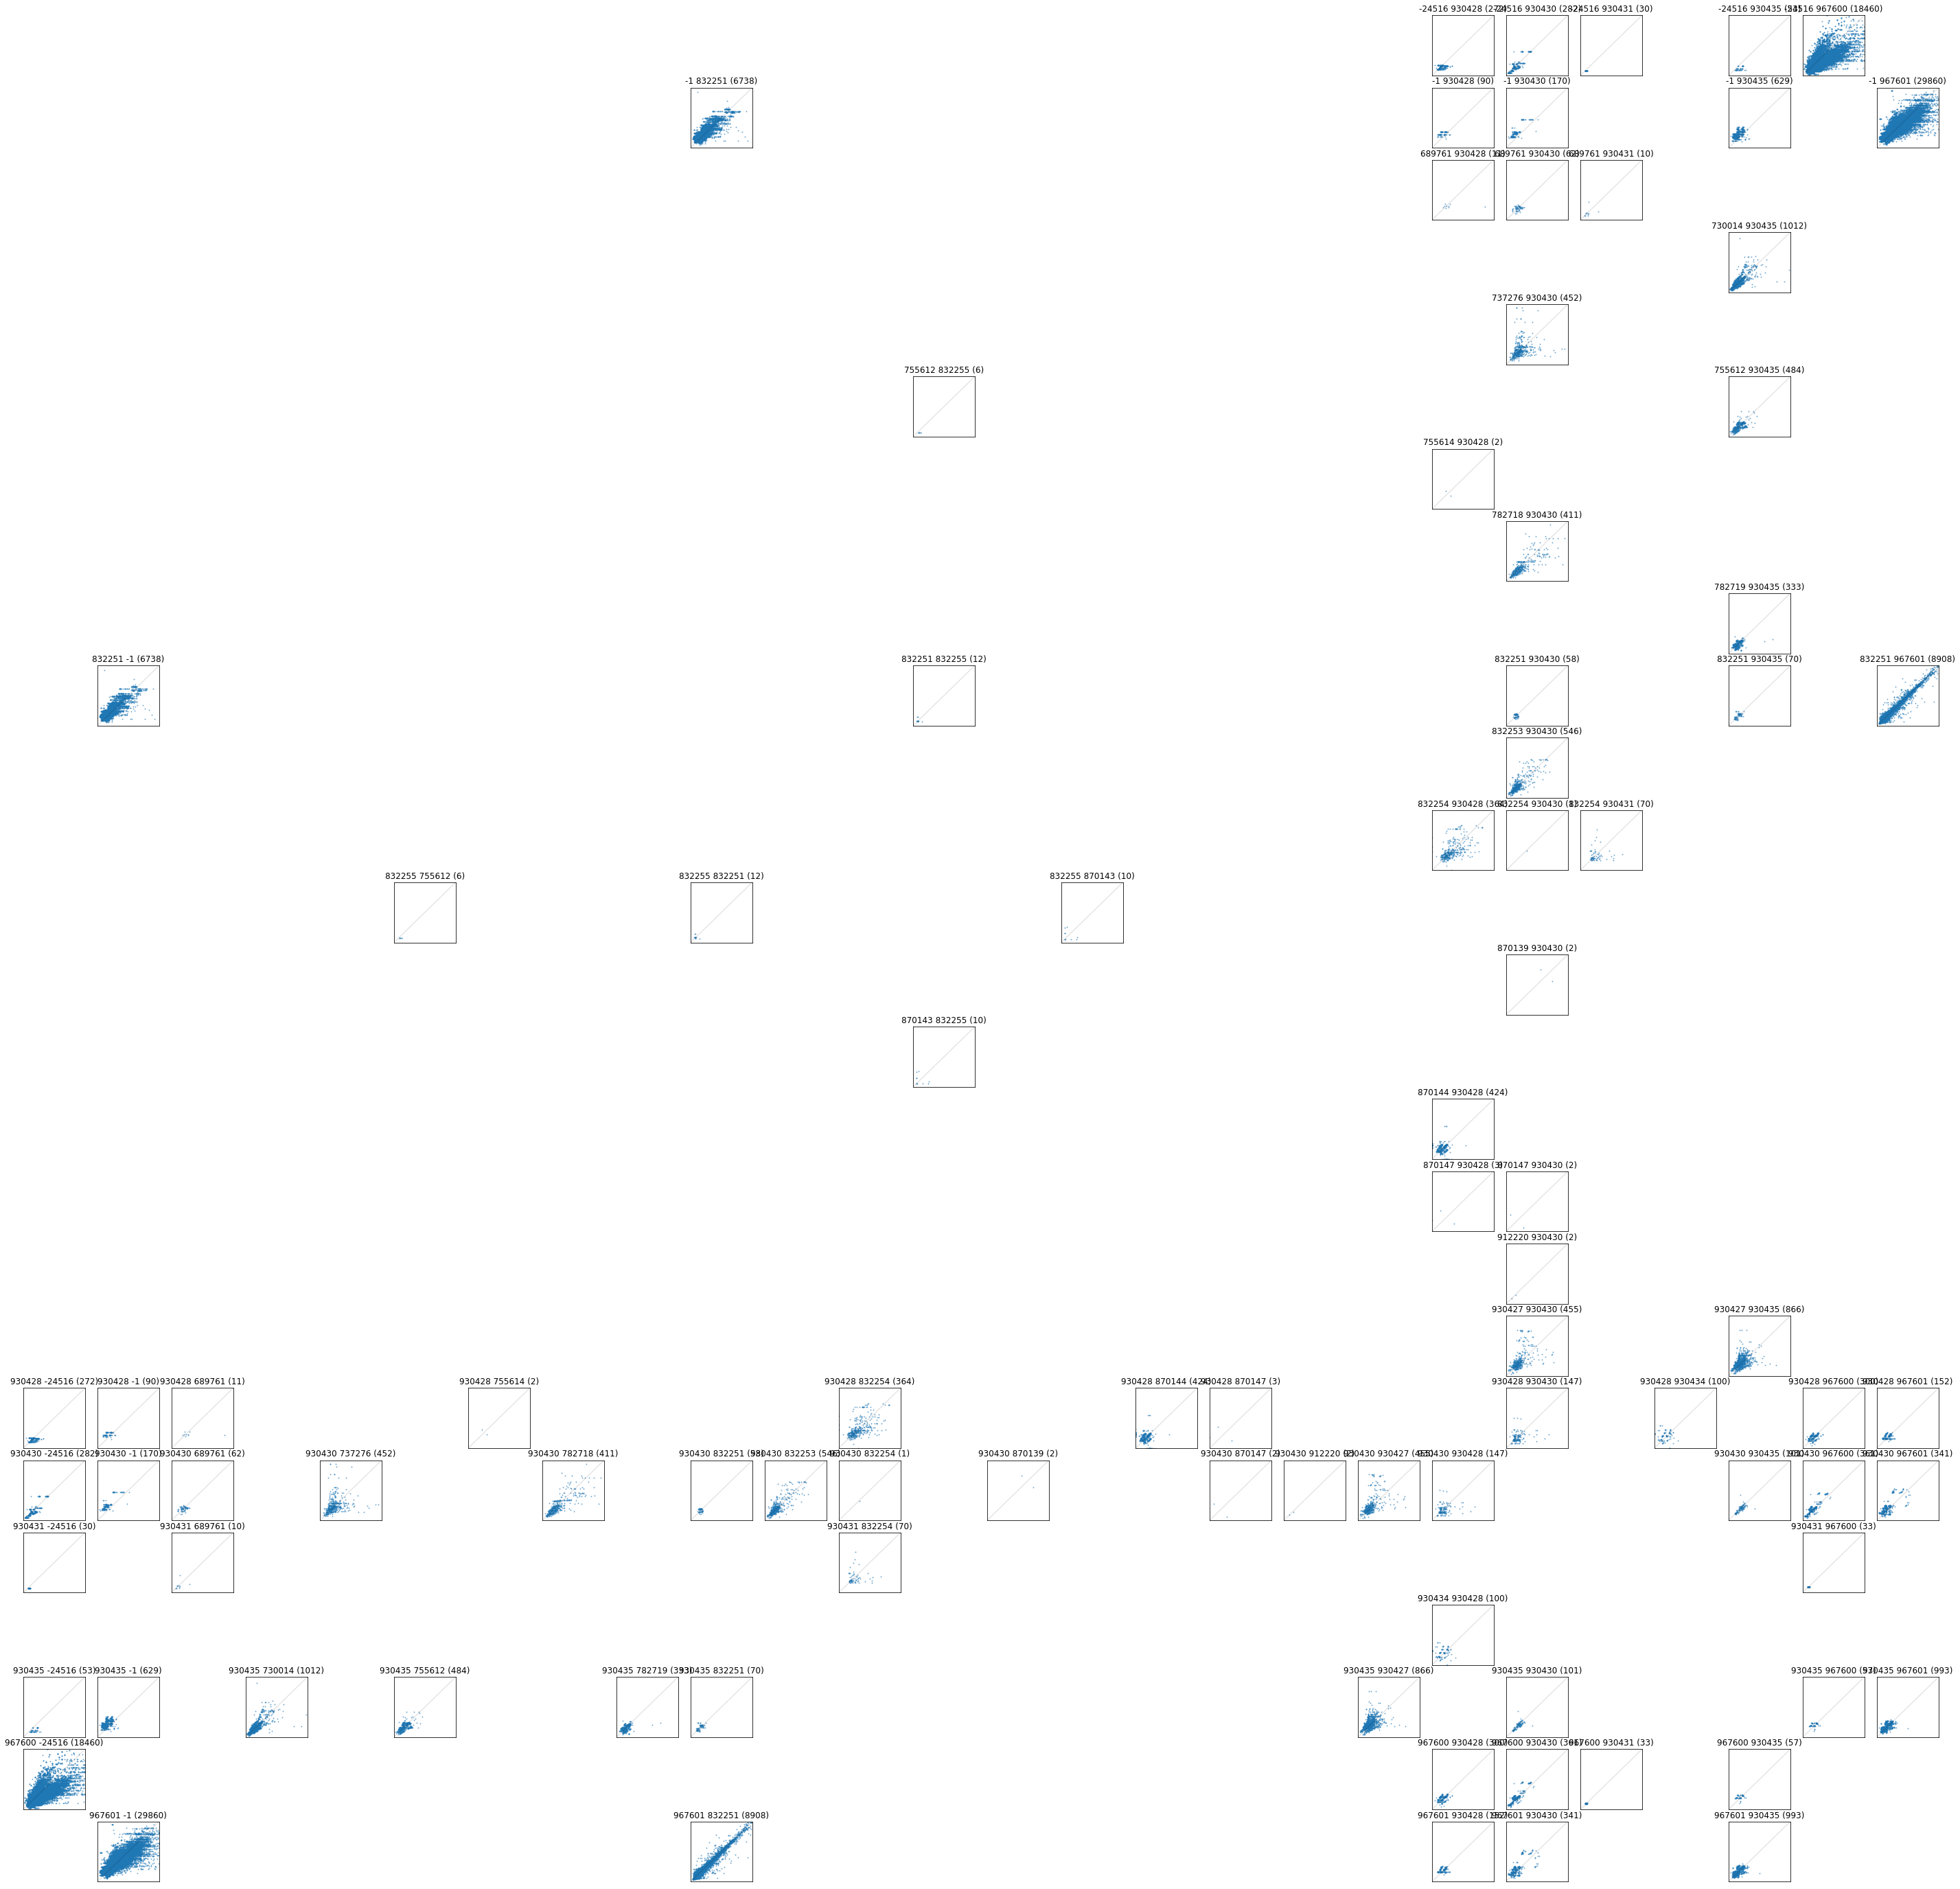

In [36]:
j = 0
plt.figure(figsize=[50,50])
tot = 0
for iA,idA in enumerate(unq):
    for iB,idB in enumerate(unq):
        j+=1
        encs = encounters[((encounters['channel_id_sensorA']==idA) & (encounters['channel_id_sensorB']==idB)) | ((encounters['channel_id_sensorA']==idB) & (encounters['channel_id_sensorB']==idA))]
        if len(encs)==0: continue
        tot+=len(encs)
        plt.subplot(len(unq),len(unq),j)
        plt.scatter(encs['pm2_5_sensorA'],encs['pm2_5_sensorB'],1,alpha=0.5)
        plt.xlim([0,200])
        plt.ylim([0,200])
        plt.xticks([],[])
        plt.yticks([],[])
        plt.grid()
        plt.plot([0,200],[0,200],'k-',alpha=0.1)
        plt.title("%d %d (%d)" % (int(idA),int(idB),len(encs)))
        #print(len(encounters[(encounters['channel_id_sensorA']==idA) & (encounters['channel_id_sensorB']==idB)]))

(10.0, 70.0)

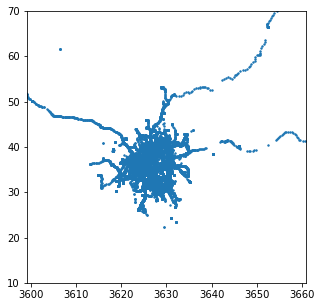

In [37]:
plt.figure(figsize=[5,5])
plt.axis('equal')
plt.scatter(df['x']/1e3,df['y']/1e3,2)
plt.xlim([3610,3650])
plt.ylim([10,70])

This is a plot with x-axis=time and y-axis is each sensor.
Each vertical line is a colocation event.

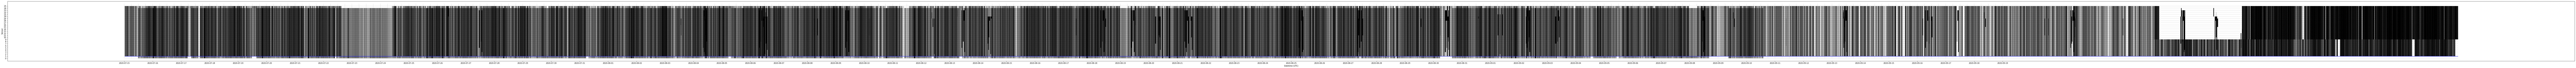

In [39]:
def getunqindex(unq,df):
    return [np.where(a==unq)[0][0] for a in df]
plt.figure(figsize=[250,6])
plt.vlines(encounters['created_at'][::1],
getunqindex(unq,encounters['channel_id_sensorA'])[::1],
getunqindex(unq,encounters['channel_id_sensorB'])[::1],alpha=0.2)
plt.hlines(np.arange(0,len(unq)),min(encounters['created_at']),max(encounters['created_at']),'k',alpha=0.1)
plt.hlines(getunqindex(unq,[-1]),min(encounters['created_at']),max(encounters['created_at']),'b')
plt.xlabel('Datetime (UTC)')
plt.ylabel('Sensor')
plt.yticks(np.arange(0,len(unq)),np.arange(0,len(unq)));
days = pd.date_range(pd.Timestamp('2020-07-15'),pd.Timestamp('2020-09-19'),freq=pd.Timedelta(1,'day'))
plt.xticks(days,days.strftime('%Y-%m-%d'));
hours = pd.date_range(pd.Timestamp('2020-07-15'),pd.Timestamp('2020-09-19'),freq=pd.Timedelta(6,'hour'))
plt.vlines(hours,0,len(unq),'k',alpha=0.1)

In [62]:
#a = encounters[(encounters['created_at']>=pd.Timestamp('2020-08-04',tz='UTC')) & (encounters['created_at']<pd.Timestamp('2020-08-05',tz='UTC'))][['channel_id_sensorA','channel_id_sensorB']]#.drop_duplicates()
#swap = a['channel_id_sensorA']<a['channel_id_sensorB']
#As = a.loc[swap,'channel_id_sensorA']
#a.loc[swap,'channel_id_sensorA'] = a.loc[swap,'channel_id_sensorB']
#a.loc[swap,'channel_id_sensorB'] = As
##encounters = 
#d = a.drop_duplicates()[['channel_id_sensorA','channel_id_sensorB']].astype(int)
#d.to_numpy()


In [63]:
#for i,r in encounters[(encounters['created_at']>=pd.Timestamp('2020-08-04',tz='UTC')) & (encounters['created_at']<pd.Timestamp('2020-08-05',tz='UTC'))][['created_at','channel_id_sensorA','channel_id_sensorB']].sort_values('created_at')[::].iterrows():
#    if r[1]==967601: continue
#    if r[2]==967601: continue
#    print("%s %8d  -%8d"%(r[0].strftime("%H:%M:%S"),r[1],r[2]))

In [64]:
#encounters['created_at']

# Looking at Calibration

This section applies calibration methods

In [6]:
import pandas as pd
from google.cloud import bigquery
import numpy as np
import pickle
import gpflow
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from gpflow.utilities import print_summary
import download_airnow_web
import pyproj
%matplotlib inline

In [7]:
df = pickle.load(open('alldataprocessed.p','rb'))
encounters = pickle.load(open('encounters.p','rb'))
unq = df['channel_id'].unique()

In [8]:
encounters

,created_at,channel_id_sensorA,pm2_5_sensorA,s2_pm2_5_sensorA,latitude_sensorA,longitude_sensorA,temperature_sensorA,humidity_sensorA,x_sensorA,y_sensorA,...,s2_pm2_5_sensorB,latitude_sensorB,longitude_sensorB,temperature_sensorB,humidity_sensorB,x_sensorB,y_sensorB,created_at_2_sensorB,dist,timedelta
18133,2020-08-06 12:58:11+00:00,782718.0,62.30,67.40,0.344066,32.553383,0.0,NaN,3.623826e+06,38301.482119,...,158.00,0.344084,32.553303,38.0,0.0,3.623817e+06,38303.485905,2020-08-06 12:59:02+00:00,9.128206,00:00:51
18134,2020-08-06 12:59:33+00:00,782718.0,79.45,78.00,0.344076,32.553375,0.0,NaN,3.623825e+06,38302.595333,...,64.67,0.344091,32.553291,38.0,0.0,3.623816e+06,38304.265156,2020-08-06 12:59:47+00:00,9.498761,00:00:14
18135,2020-08-06 13:01:03+00:00,782718.0,44.23,43.63,0.344051,32.553394,0.0,27769.0,3.623827e+06,38299.812296,...,49.00,0.344143,32.553288,38.0,0.0,3.623815e+06,38310.053874,2020-08-06 13:01:01+00:00,15.624556,00:00:02
18136,2020-08-06 13:02:26+00:00,782718.0,45.45,42.93,0.344053,32.553337,0.0,27749.0,3.623821e+06,38300.034939,...,43.00,0.344061,32.553234,39.0,0.0,3.623809e+06,38300.925511,2020-08-06 13:02:28+00:00,11.500441,00:00:02
18137,2020-08-06 13:03:48+00:00,782718.0,40.30,40.13,0.344051,32.553375,0.0,27749.0,3.623825e+06,38299.812296,...,50.33,0.344038,32.553268,39.0,0.0,3.623813e+06,38298.365117,2020-08-06 13:03:37+00:00,11.998778,00:00:11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1946,2020-10-04 16:00:00+00:00,-1.0,50.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,40.10,0.299279,32.592659,0.0,0.0,3.628198e+06,33315.737383,2020-10-04 15:59:26+00:00,14.648596,00:00:34
1947,2020-10-04 17:00:00+00:00,-1.0,59.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,43.15,0.299269,32.592655,0.0,0.0,3.628198e+06,33314.624173,2020-10-04 16:59:46+00:00,14.748094,00:00:14
1948,2020-10-04 18:00:00+00:00,-1.0,58.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,36.88,0.299244,32.592690,0.0,0.0,3.628202e+06,33311.841148,2020-10-04 17:59:25+00:00,19.511807,00:00:35
1949,2020-10-04 19:00:00+00:00,-1.0,48.00,NaN,0.299333,32.592539,NaN,NaN,3.628185e+06,33321.748717,...,39.10,0.299258,32.592617,0.0,0.0,3.628194e+06,33313.399642,2020-10-04 18:59:39+00:00,12.045753,00:00:21


In [9]:
#plt.figure(figsize=[20,5])
#plt.plot(np.r_[(encounters['pm2_5_sensorA']-encounters['s2_pm2_5_sensorA']),(encounters['pm2_5_sensorB']-encounters['s2_pm2_5_sensorB'])].T)
#plt.ylim([-50,50])

In [10]:
#plt.plot(np.mean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1).to_numpy())

In [11]:
#plt.plot(np.nanmean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1))

Building two simple numpy matrices:
X and Y.
X has three columns:
Time (in hours since 15th July, 2020), SensorA, SensorB

Y has two columns, the two measurements.

(I combine the two sensors on the AirQo units).
(Only use data since 15th July).

In [12]:
t = (encounters['created_at']-pd.Timestamp('2020-07-15',tz='UTC')).dt.total_seconds()/3600 #hours since 15th July
idA = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorA']]
idB = [np.where(a==unq)[0][0] for a in encounters['channel_id_sensorB']]
sA = np.nanmean(encounters[['pm2_5_sensorA','s2_pm2_5_sensorA']],1)
sB = np.nanmean(encounters[['pm2_5_sensorB','s2_pm2_5_sensorB']],1)
X = np.c_[t,idA,idB]
Y = np.c_[sA,sB]

Plot all the colocation events together to get an idea of how similar pairs will be & if there's structure in the data.

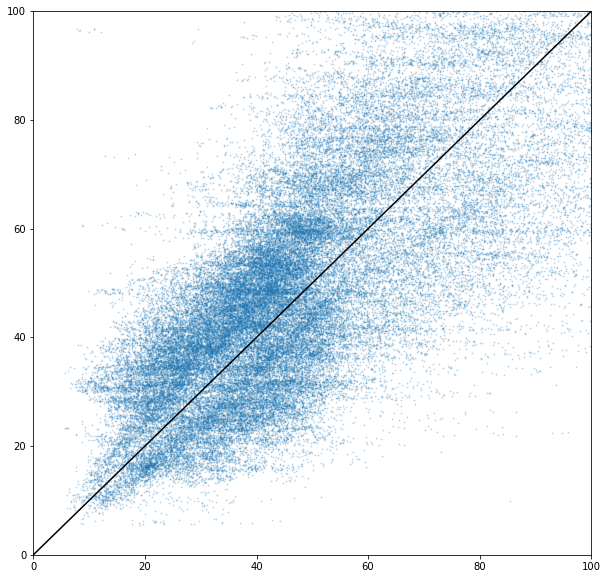

In [13]:
plt.figure(figsize=[10,10])
plt.scatter(Y[:,0]+np.random.rand(len(Y)),Y[:,1]+np.random.rand(len(Y)),1,alpha=0.2)
plt.xlim([0,100])
plt.ylim([0,100])
plt.plot([0,100],[0,100],'k-')

In [14]:
#delete a chunk in the middle so we can have a look at cross-validation.
#keep = ((X[:,0]<600) | (X[:,0]>1000) | ((X[:,1]!=57) & (X[:,2]!=57)))
#X = X[keep,:]
#Y = Y[keep,:]
#X[(X[:,0]>800) & (X[:,2]==57),2]=58
#X[(X[:,0]>800) & (X[:,1]==57),1]=58
#refsensor = np.zeros(len(unq)+1)
#refsensor[-2:]=1

Here we specify which of the sensors we believe is 'correct'. 
The last sensor is the embassy. If we just make the embassy a reference sensor, then we can see how close the calibration is to '1' for the other BAM sensor (at the university).

In [28]:
refsensor = np.zeros(len(unq))
refsensor[-1]=1
#refsensor[-2]=1

This makes it so the smaller id is always first in the pair

In [29]:
swaps = X[:,2]<X[:,1]
X[swaps,1],X[swaps,2] = X[swaps,2],X[swaps,1]
Y[swaps,1],Y[swaps,0] = Y[swaps,0],Y[swaps,1]

In [30]:
def compute_simple_calibration(X,Y,delta):
    """
    Compute the calibration scaling for each sensor.
    
    For a chunk of time, specified by 'delta' hours,
    we take all the colocation data and find the
    average log ratio for each pair of sensors.
    
    We then find the shortest path through
    the network from the reference sensor(s)
    to each unit, adding up the log ratios.
    
    Returns:
    allscales = the log scaling for each sensor, for each
    time chunk (specified by delta).
    alldists, allerrs
    """
    allscales = []
    alldists = []
    allerrs = []
    for starttime in np.arange(0,np.max(X[:,0]),delta):
        keep = (X[:,0]>starttime) & (X[:,0]<starttime+delta)
        Xkeep = X[keep,:]
        Ykeep = Y[keep,:]
        maxnum = int(np.max(X[:,1:]))
        data = np.full([maxnum+1,maxnum+1],np.NaN)
        dataerr = np.zeros([maxnum+1,maxnum+1])

        idx=0
        for i in range(maxnum+1):
            for j in range(maxnum+1):
                keep = (Xkeep[:,1]==i) & (Xkeep[:,2]==j)
                if len(Ykeep[keep,0])>0: #need a few data points for confidence?
                    var = np.var(np.log(Ykeep[keep,0]/Ykeep[keep,1]))
                    #in theory the number of observations should matter
                    #but we are probably less interested in the uncertainty in the
                    #population mean and more in the samples...
                    dataerr[i,j] = var #1/np.sqrt(np.sum(keep))
                    dataerr[j,i] = var #1/np.sqrt(np.sum(keep))
                    data[i,j]=np.mean(np.log(Ykeep[keep,0]/Ykeep[keep,1]))
                    data[j,i]=np.mean(np.log(Ykeep[keep,1]/Ykeep[keep,0]))
                    #assert False
        scales = np.full(maxnum+1,np.NaN)
        scales[refsensor==1]=0
        mindist = np.full(maxnum+1,100)
        mindist[refsensor==1]=0
        errs = np.full(maxnum+1,100.0)
        errs[refsensor==1]=0
        paths = np.full(maxnum+1,np.NaN)
        for it2 in range(maxnum+1):
            for it in range(maxnum+1):
                #print(it)
                conns = ~np.isnan(data[it,:])
                #print(conns)
                shorterconns = (~np.isnan(data[it,:])) & (mindist>1+mindist[it])
                paths[shorterconns]=it #np.arange(0,maxnum+1)[shorterconns]
                scales[shorterconns]=scales[it]+data[shorterconns,it] #np.arange(0,maxnum+1)[shorterconns]
                errs[shorterconns]=errs[it]+dataerr[shorterconns,it]
                mindist[conns]=np.min([mindist[conns],np.ones(sum(conns))+mindist[it]],0)
        allerrs.append(errs)        
        allscales.append(scales)
        alldists.append(mindist)
    allscales = np.array(allscales)
    alldists=np.array(alldists)
    allerrs=np.array(allerrs)
    return allscales, alldists, allerrs
    
    def plotbars(xs,delta,ys,c='k'):
        for x,y in zip(xs,ys):
            plt.hlines(y,x,x+delta,c,lw=3,zorder=20)

In [31]:
delta = 24*3 #size of chunk of time for each calibration network
allscales, alldists, allerrs = compute_simple_calibration(X,Y,delta=delta)

<ipython-input-30-03057e5e2563>:34: RuntimeWarning: invalid value encountered in log
  var = np.var(np.log(Ykeep[keep,0]/Ykeep[keep,1]))
<ipython-input-30-03057e5e2563>:40: RuntimeWarning: invalid value encountered in log
  data[i,j]=np.mean(np.log(Ykeep[keep,0]/Ykeep[keep,1]))
<ipython-input-30-03057e5e2563>:41: RuntimeWarning: invalid value encountered in log
  data[j,i]=np.mean(np.log(Ykeep[keep,1]/Ykeep[keep,0]))


This plot shows how many hops there are from each sensor to the reference sensor(s).

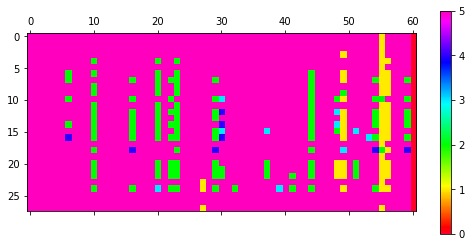

In [32]:
plt.matshow(alldists,cmap='gist_rainbow')#alldists[:,np.any(alldists<100,0)])#alldists)#,cmap='gist_rainbow')
plt.clim([0,5])
plt.colorbar()

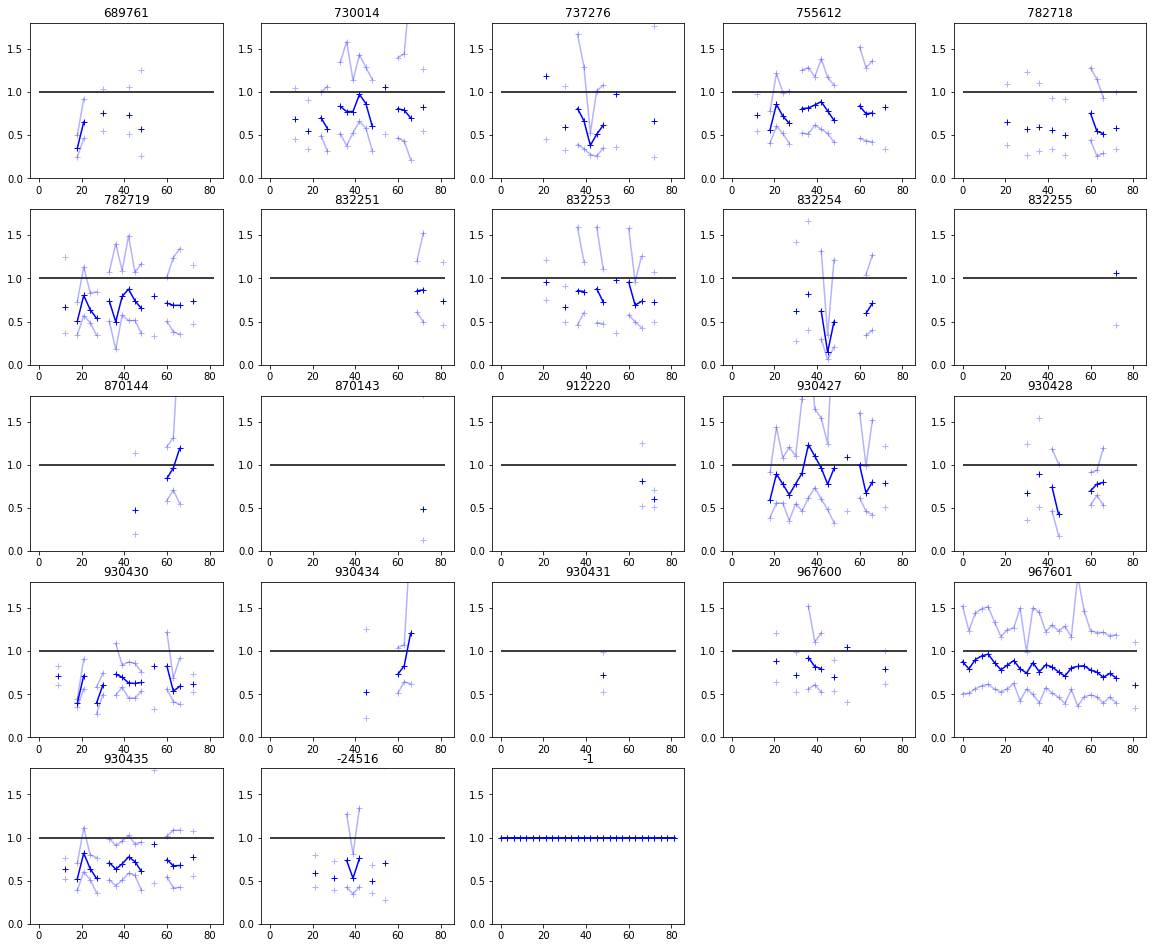

In [33]:
i=1
plt.figure(figsize=[20,20])
for idx,(scale,dist,err) in enumerate(zip(allscales.T,alldists.T,allerrs.T)):
    if np.all(np.isnan(scale)): continue
    #d = np.sqrt(dist*0.05)
    d = 2*np.sqrt(err) #+np.sqrt(dist*0.025)
    plt.subplot(6,5,i)
    i+=1
    plt.plot(np.arange(0,np.max(X[:,0]),delta)/24,np.exp(scale),'+-b');
    plt.plot(np.arange(0,np.max(X[:,0]),delta)/24,np.exp(scale-d),'+-b',alpha=0.3);
    plt.plot(np.arange(0,np.max(X[:,0]),delta)/24,np.exp(scale+d),'+-b',alpha=0.3);
    plt.ylim([0,1.8])
    #plt.xticks([],[])
    plt.title("%d" % unq[idx])#str(dist[dist<100]))
    plt.hlines(1,0,np.max(X[:,0])/24)
#plt.legend()

The above plots show the estimated expected calibration sclaing for each sensor.

Worryingly the BAM sensor at Makerere (-24516) has a calibration value much less than one.

<div style="height:500px;" />

# Ignore Below This Line
<hr>
The following is messing with fitting a GP and other thoughts, looking at how to handle the fact that not every 5 day block has colocations between all sensors.

In [16]:
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary

# The lines below are specific to the notebook format
#%matplotlib inline
#plt.rcParams["figure.figsize"] = (12, 6)

In [17]:
times = np.zeros([0,2])
scales = np.zeros([0,1])
errs = np.zeros([0,1])

for i,(s,e) in enumerate(zip(allscales.T, allerrs.T)):
    keep = ~np.isnan(s)
    newts = np.arange(0,np.max(X[:,0]),delta)[keep,None]
    times = np.r_[times,np.c_[newts,np.full_like(newts,i)]]
    scales = np.r_[scales,s[keep][:,None]]
    errs = np.r_[errs,e[keep][:,None]]

In [18]:
best = np.inf
bestm = None
for ls in np.logspace(np.log10(24),np.log10(2400),20):
    print(".",end="")
    k = gpflow.kernels.RBF(lengthscales=[ls,0.001],variance=0.1,active_dims=[0,1])+ gpflow.kernels.Bias()
        #+gpflow.kernels.RBF(lengthscales=1e-4,variance=0.01,active_dims=[1]) 
        
    m = gpflow.models.GPR(data=(times,scales), kernel=k, mean_function=None)
    #m.kernel.kernels[0].lengthscales.prior = tfp.distributions.Gamma(50.0,10.0)
    #m.likelihood.variance.assign(1e-5)
    #gpflow.set_trainable(m.kernel.kernels[0].variance,False)
    gpflow.set_trainable(m.kernel.kernels[0].lengthscales,False)
   #gpflow.set_trainable(m.kernel.kernels[1].lengthscales,False)

    opt = gpflow.optimizers.Scipy()
    def objective_closure():
        return - m.log_marginal_likelihood() - m.log_prior_density()

    opt_logs = opt.minimize(objective_closure,
                            m.trainable_variables,
                            options=dict(maxiter=100))
    print("%0.5f %0.2f" % (ls,opt_logs['fun']))
    print(m.log_prior_density())
    if opt_logs['fun']<best:
        best = opt_logs['fun']
        bestm = m

.24.00000 -40.43
tf.Tensor(0.0, shape=(), dtype=float64)
.30.58260 -40.46
tf.Tensor(0.0, shape=(), dtype=float64)
.38.97064 -40.95
tf.Tensor(0.0, shape=(), dtype=float64)
.49.65931 -43.42
tf.Tensor(0.0, shape=(), dtype=float64)
.63.27962 -48.04
tf.Tensor(0.0, shape=(), dtype=float64)
.80.63564 -50.87
tf.Tensor(0.0, shape=(), dtype=float64)
.102.75198 -52.37
tf.Tensor(0.0, shape=(), dtype=float64)
.130.93427 -54.99
tf.Tensor(0.0, shape=(), dtype=float64)
.166.84627 -58.27
tf.Tensor(0.0, shape=(), dtype=float64)
.212.60803 -61.90
tf.Tensor(0.0, shape=(), dtype=float64)
.270.92109 -65.76
tf.Tensor(0.0, shape=(), dtype=float64)
.345.22797 -69.42
tf.Tensor(0.0, shape=(), dtype=float64)
.439.91537 -72.47
tf.Tensor(0.0, shape=(), dtype=float64)
.560.57315 -74.92
tf.Tensor(0.0, shape=(), dtype=float64)
.714.32435 -76.89
tf.Tensor(0.0, shape=(), dtype=float64)
.910.24565 -78.40
tf.Tensor(0.0, shape=(), dtype=float64)
.1159.90326 -79.44
tf.Tensor(0.0, shape=(), dtype=float64)
.1478.03571 -80.06


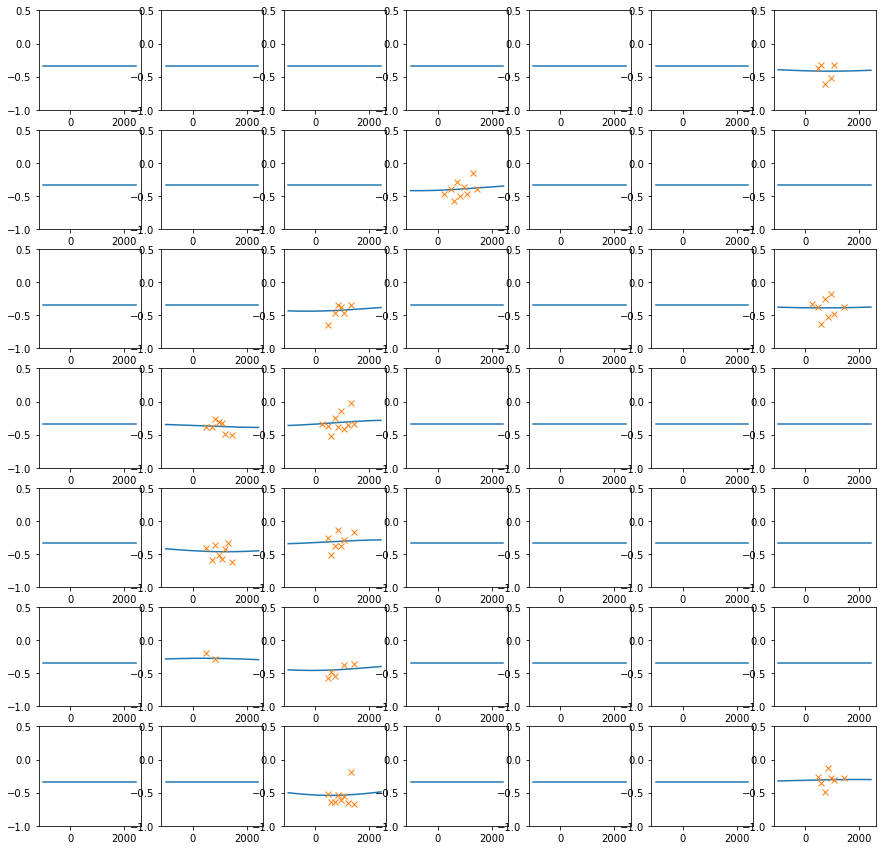

In [19]:
plt.figure(figsize=[15,15])
for i in range(49):
    plt.subplot(7,7,i+1)
    fulltimes = np.arange(0-1000,np.max(times)+1000,delta/10)[:,None]
    fulltimes = np.c_[fulltimes,np.full_like(fulltimes,i)]
    predm, predv = bestm.predict_f(fulltimes)
    plt.plot(fulltimes[:,0],predm)
    plt.plot(times[times[:,1]==i,0],scales[times[:,1]==i],'x')
    plt.ylim([-1,0.5])

In [20]:
fulltimes

array([[-1000.,    48.],
       [ -988.,    48.],
       [ -976.,    48.],
       [ -964.,    48.],
       [ -952.,    48.],
       [ -940.,    48.],
       [ -928.,    48.],
       [ -916.,    48.],
       [ -904.,    48.],
       [ -892.,    48.],
       [ -880.,    48.],
       [ -868.,    48.],
       [ -856.,    48.],
       [ -844.,    48.],
       [ -832.,    48.],
       [ -820.,    48.],
       [ -808.,    48.],
       [ -796.,    48.],
       [ -784.,    48.],
       [ -772.,    48.],
       [ -760.,    48.],
       [ -748.,    48.],
       [ -736.,    48.],
       [ -724.,    48.],
       [ -712.,    48.],
       [ -700.,    48.],
       [ -688.,    48.],
       [ -676.,    48.],
       [ -664.,    48.],
       [ -652.,    48.],
       [ -640.,    48.],
       [ -628.,    48.],
       [ -616.,    48.],
       [ -604.,    48.],
       [ -592.,    48.],
       [ -580.,    48.],
       [ -568.,    48.],
       [ -556.,    48.],
       [ -544.,    48.],
       [ -532.,    48.],


In [21]:
k = gpflow.kernels.Matern52(1, lengthscales=0.3)
m = gpflow.models.GPR(X, Y)
m.likelihood.variance = 0.01
m.compile()

ValueError: too many values to unpack (expected 2)

In [ ]:
# low cost next to BAM at Makerere (24516) = 967600


In [159]:
what are these sensors? : )
930430. <-- mobile?
930428. <-- mobile?
930435. <-- mobile device 
930431. <<??

array([967600., 930430., 930428.])

[967600. 930430. 930428. 930435. 930431.]
[967600. 930430. 930428.]


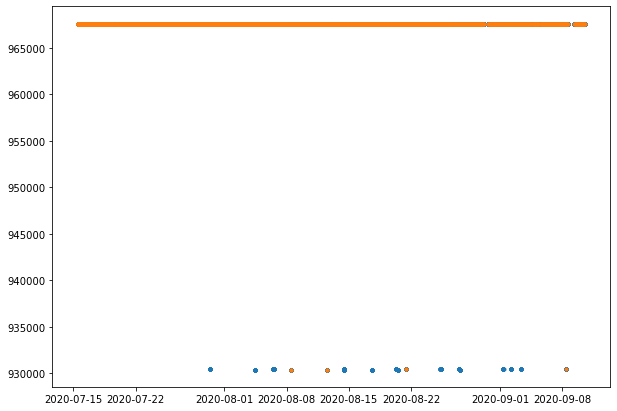

In [160]:
enc = encounters[encounters['channel_id_sensorB']==-24516]
print(enc['channel_id_sensorA'].unique())
plt.figure(figsize=[10,7])
plt.plot(enc['created_at'],enc['channel_id_sensorA'],'.')
enc = encounters[encounters['channel_id_sensorA']==-24516]
plt.plot(enc['created_at'],enc['channel_id_sensorB'],'.')
print(enc['channel_id_sensorB'].unique())

In [145]:
encounters[encounters['channel_id_sensorA']==-24516]

,created_at,channel_id_sensorA,pm2_5_sensorA,s2_pm2_5_sensorA,latitude_sensorA,longitude_sensorA,temperature_sensorA,humidity_sensorA,x_sensorA,y_sensorA,...,s2_pm2_5_sensorB,latitude_sensorB,longitude_sensorB,temperature_sensorB,humidity_sensorB,x_sensorB,y_sensorB,created_at_2_sensorB,dist,timedelta
45,2020-07-15 12:00:00+00:00,-24516.0,22.1,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,36.65,0.333511,32.568550,45.0,0.0,3.625514e+06,37126.484351,2020-07-15 12:07:28+00:00,3.078947,00:07:28
46,2020-07-15 12:00:00+00:00,-24516.0,22.1,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,36.65,0.333511,32.568550,45.0,0.0,3.625514e+06,37126.484351,2020-07-15 12:07:28+00:00,3.078947,00:07:28
47,2020-07-15 12:00:00+00:00,-24516.0,22.1,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,36.65,0.333511,32.568550,45.0,0.0,3.625514e+06,37126.484351,2020-07-15 12:07:28+00:00,3.078947,00:07:28
48,2020-07-15 12:00:00+00:00,-24516.0,22.1,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,36.65,0.333511,32.568550,45.0,0.0,3.625514e+06,37126.484351,2020-07-15 12:07:28+00:00,3.078947,00:07:28
49,2020-07-15 13:00:00+00:00,-24516.0,20.8,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,36.82,0.333482,32.568565,44.0,0.0,3.625516e+06,37123.256031,2020-07-15 13:02:26+00:00,2.887916,00:02:26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3200,2020-09-08 10:00:00+00:00,-24516.0,15.9,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,17.40,0.333411,32.568493,47.0,0.0,3.625508e+06,37115.352213,2020-09-08 09:59:48+00:00,14.033454,00:00:12
2053,2020-08-08 11:00:00+00:00,-24516.0,33.7,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,27.67,0.333437,32.568508,38.0,0.0,3.625510e+06,37118.246569,2020-08-08 11:00:10+00:00,10.784300,00:00:10
2054,2020-08-08 11:00:00+00:00,-24516.0,33.7,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,27.67,0.333437,32.568508,38.0,0.0,3.625510e+06,37118.246569,2020-08-08 11:00:10+00:00,10.784300,00:00:10
2241,2020-08-12 12:00:00+00:00,-24516.0,24.1,NaN,0.333505,32.568577,NaN,NaN,3.625517e+06,37125.816422,...,34.33,0.333420,32.568569,43.0,0.0,3.625517e+06,37116.354105,2020-08-12 12:00:08+00:00,9.504132,00:00:08


In [ ]:
#'BAM Metadata.xlsx'  'Y24516 Makerere BAM'/  'Y24517 Nakawa BAM'/